Timestamp diagnostic per meter_type (before clipping):
  meter_type                 min                 max  count  nunique
chilledwater 2016-01-02 12:00:00 2017-12-31 23:00:00  67375    13616
 electricity 2016-01-02 12:00:00 2017-12-31 23:00:00 177731    14025
         gas 2016-01-05 04:00:00 2017-12-31 20:00:00  16341     7000
    hotwater 2016-01-02 12:00:00 2017-12-31 23:00:00  25856    10609
  irrigation 2016-01-05 04:00:00 2017-12-31 20:00:00  14771     7905
       steam 2016-11-04 18:00:00 2017-12-13 00:00:00    203       51
       water 2016-01-05 04:00:00 2017-12-31 20:00:00  38332     9373

Out-of-range timestamps (outside 2017–2018): 214395 / 340609  |  NaT: 0


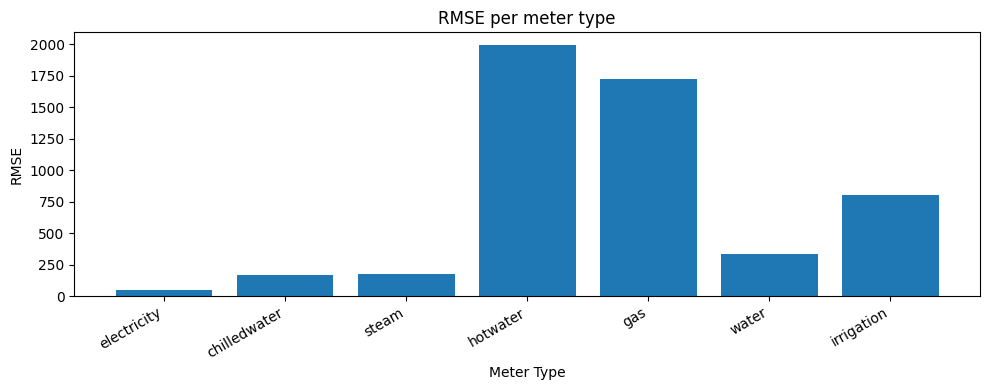

  RMSE per meter type  
electricity: RMSE=51.6955
chilledwater: RMSE=170.6459
steam: RMSE=175.0919
hotwater: RMSE=1995.5412
gas: RMSE=1726.8018
water: RMSE=334.2331
irrigation: RMSE=805.6745


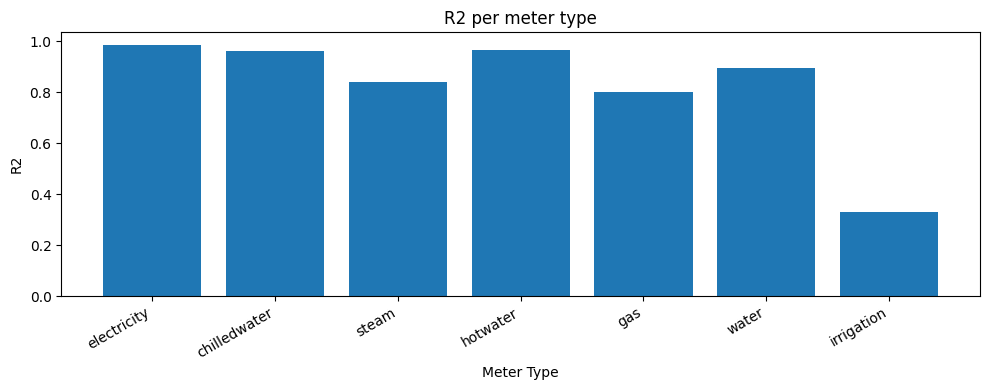

  R2 per meter type  
electricity: R2=0.9849
chilledwater: R2=0.9598
steam: R2=0.8391
hotwater: R2=0.9663
gas: R2=0.7992
water: R2=0.8926
irrigation: R2=0.3314

  MAE per meter type  
electricity: MAE=17.7213
chilledwater: MAE=71.9788
steam: MAE=97.4319
hotwater: MAE=629.5360
gas: MAE=533.8855
water: MAE=109.2602
irrigation: MAE=129.6089


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
from matplotlib.ticker import NullLocator


# ---------------------------------------------------------------------
# 유틸: datetime 축 라벨 과밀/겹침 방지 (월 단위 눈금, 깔끔 포맷)
# ---------------------------------------------------------------------
def _maybe_format_timeaxis(ax, x_series):
    """x가 datetime이면 보기 좋은 눈금/포맷 적용 + 라벨 과밀/겹침 방지"""
    if isinstance(x_series, pd.Series) and not x_series.empty:
        # datetime 강제 + tz 제거
        try:
            x_series = pd.to_datetime(x_series, errors="coerce").dt.tz_localize(None)
        except Exception:
            return

        # 축 범위를 명시해줘야 Matplotlib이 날짜축으로 확실히 인식
        try:
            xmin, xmax = x_series.min(), x_series.max()
            if pd.notna(xmin) and pd.notna(xmax):
                ax.set_xlim(xmin, xmax)
        except Exception:
            pass

        major = mdates.MonthLocator(interval=1)             # 월 단위
        ax.xaxis.set_major_locator(major)
        ax.xaxis.set_minor_locator(NullLocator())    # 보조 눈금 제거(겹침 방지)

        # 라벨 포맷: ConciseDateFormatter가 더 깔끔 (미지원 환경이면 YYYY-MM 폴백)
        try:
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(major))
        except Exception:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        for lab in ax.get_xticklabels():
            lab.set_rotation(30)
            lab.set_ha('right')
        ax.figure.subplots_adjust(bottom=0.20)


# ---------------------------------------------------------------------
# 경로/파일
# ---------------------------------------------------------------------
RESULTS_DIR = Path("../results")
PRED_CSV    = RESULTS_DIR / "preds_all.csv"
POLICY_CSV  = RESULTS_DIR / "policy_events_ready.csv"
METRICS_CSV = RESULTS_DIR / "metrics_per_meter.csv"

# ---------------------------------------------------------------------
# 로드
# ---------------------------------------------------------------------
dfs = {}
if PRED_CSV.exists():
    dfs["preds"] = pd.read_csv(PRED_CSV)
if POLICY_CSV.exists():
    dfs["policy"] = pd.read_csv(POLICY_CSV)
if METRICS_CSV.exists():
    dfs["metrics"] = pd.read_csv(METRICS_CSV)

# ---------------------------------------------------------------------
# [PATCH] policy의 timestamp를 preds에 병합 (meter_type, seq_index 키)
#         + tz-naive로 통일 + 2017~2018 구간으로 클리핑한 preds_vis 생성
# ---------------------------------------------------------------------
if "preds" in dfs and not dfs["preds"].empty and "policy" in dfs and not dfs["policy"].empty:
    p = dfs["policy"].copy()
    need = {"meter_type", "seq_index", "timestamp"}
    if need.issubset(p.columns):
        p["timestamp"] = pd.to_datetime(p["timestamp"], errors="coerce").dt.tz_localize(None)
        d = dfs["preds"].copy()

        if "seq_index" in d.columns:
            d = pd.merge(
                d,
                p[["meter_type", "seq_index", "timestamp"]],
                on=["meter_type", "seq_index"],
                how="left",
                validate="m:1"
            )
        # 병합 결과 반영
        dfs["preds"] = d

# 2017-01-01 ~ 2018-12-31 범위만 시각화에 사용
EXPECTED_START = pd.Timestamp('2017-01-01')
EXPECTED_END   = pd.Timestamp('2018-12-31 23:59:59')

if "preds" in dfs and not dfs["preds"].empty and "timestamp" in dfs["preds"].columns:
    dfs["preds"]["timestamp"] = pd.to_datetime(dfs["preds"]["timestamp"], errors="coerce").dt.tz_localize(None)

    # 진단 출력
    diag = dfs["preds"].groupby("meter_type")["timestamp"].agg(["min","max","count","nunique"]).reset_index()
    print("Timestamp diagnostic per meter_type (before clipping):")
    print(diag.to_string(index=False))

    ts = dfs["preds"]["timestamp"]
    mask_range = ts.ge(EXPECTED_START) & ts.le(EXPECTED_END)
    n_total = len(ts)
    n_out   = int((~mask_range & ts.notna()).sum())
    n_nat   = int(ts.isna().sum())
    print(f"\nOut-of-range timestamps (outside 2017–2018): {n_out} / {n_total}  |  NaT: {n_nat}")

    dfs["preds_vis"] = dfs["preds"].loc[mask_range].copy()
else:
    dfs["preds_vis"] = dfs.get("preds", pd.DataFrame()).copy()

def _uniform_take(df, n_show):
    """df 전체 구간을 균등 간격으로 최대 n_show개까지 선택"""
    n = len(df)
    if n <= n_show:
        return df
    step = max(1, n // n_show)
    return df.iloc[::step].iloc[:n_show]


# ---------------------------------------------------------------------
# 헬퍼: x축 선택 (timestamp 우선, 없으면 seq_index)
# ---------------------------------------------------------------------
def _x_axis_series(df_slice: pd.DataFrame, fallback_col="seq_index"):
    if "timestamp" in df_slice.columns and df_slice["timestamp"].notna().any():
        return df_slice["timestamp"]
    return df_slice[fallback_col] if fallback_col in df_slice.columns else pd.Series(range(len(df_slice)))

# 시각화용 다운샘플(옵션) — 라벨 겹침/과밀 완화
def _downsample_df(df, max_points=8000):
    if len(df) <= max_points:
        return df
    step = max(1, len(df) // max_points)
    return df.iloc[::step].reset_index(drop=True)

 
# 1) RMSE per meter (bar + text)
 
if "metrics" in dfs and not dfs["metrics"].empty:
    m = dfs["metrics"].copy()
    m["RMSE"] = pd.to_numeric(m["RMSE"], errors="coerce")
    plt.figure(figsize=(10, 4))
    plt.bar(m["meter_type"], m["RMSE"])
    plt.title("RMSE per meter type")
    plt.xlabel("Meter Type")
    plt.ylabel("RMSE")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    print("  RMSE per meter type  ")
    for _, row in m.iterrows():
        try:
            print(f"{row['meter_type']}: RMSE={float(row['RMSE']):.4f}")
        except Exception:
            pass

 
# 2) R² per meter (bar + text)
 
if "metrics" in dfs and not dfs["metrics"].empty:
    m = dfs["metrics"].copy()
    m["R2"] = pd.to_numeric(m["R2"], errors="coerce")
    plt.figure(figsize=(10, 4))
    plt.bar(m["meter_type"], m["R2"])
    plt.title("R2 per meter type")
    plt.xlabel("Meter Type")
    plt.ylabel("R2")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    print("  R2 per meter type  ")
    for _, row in m.iterrows():
        try:
            print(f"{row['meter_type']}: R2={float(row['R2']):.4f}")
        except Exception:
            pass

 
# 3) MAE per meter (text)
 
if "metrics" in dfs and not dfs["metrics"].empty:
    m = dfs["metrics"].copy()
    m["MAE"] = pd.to_numeric(m["MAE"], errors="coerce")
    print("\n  MAE per meter type  ")
    for _, row in m.iterrows():
        try:
            print(f"{row['meter_type']}: MAE={float(row['MAE']):.4f}")
        except Exception:
            pass



 electricity → 2017-01-01 00:00:00 ~ 2017-12-31 23:00:00 (total 59021)


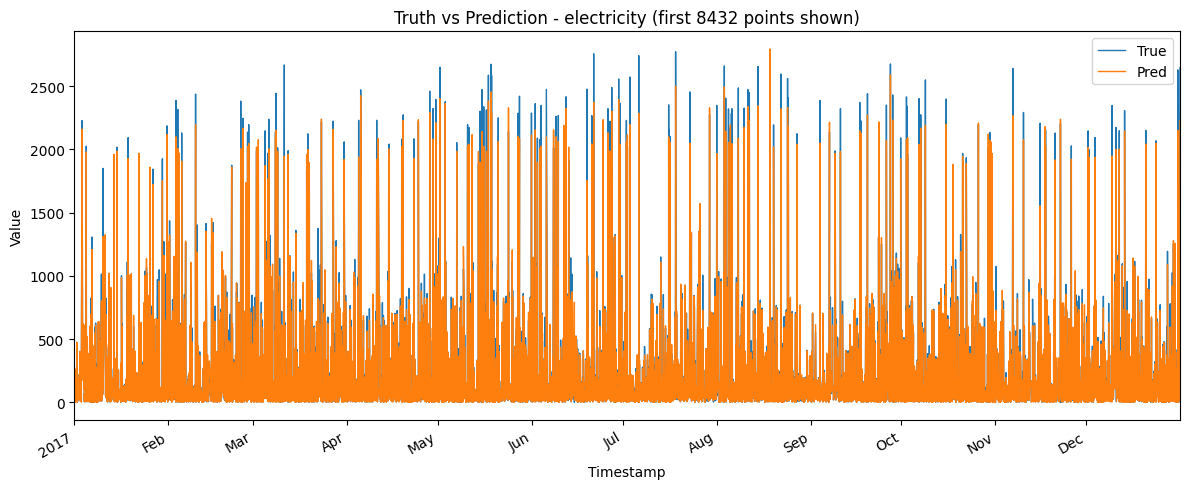


 chilledwater → 2017-01-01 00:00:00 ~ 2017-12-31 23:00:00 (total 23266)


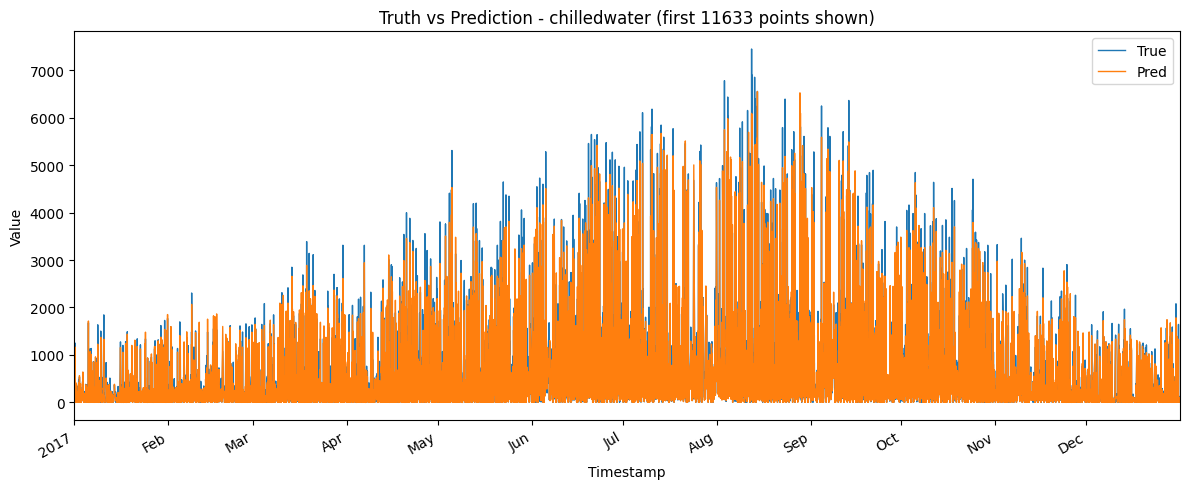


 water → 2017-01-01 00:00:00 ~ 2017-12-31 20:00:00 (total 19786)


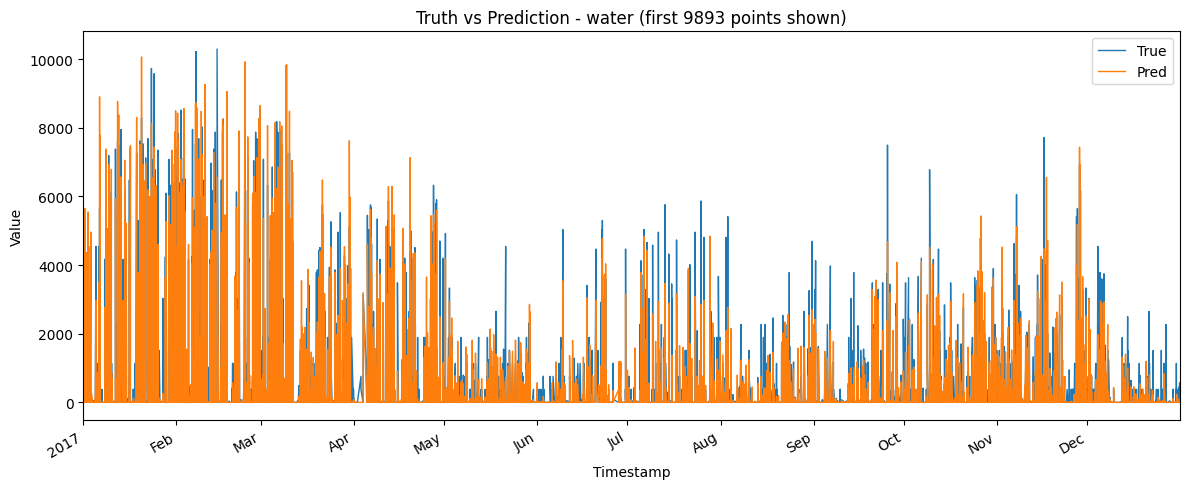


 hotwater → 2017-01-01 05:00:00 ~ 2017-12-31 23:00:00 (total 8305)


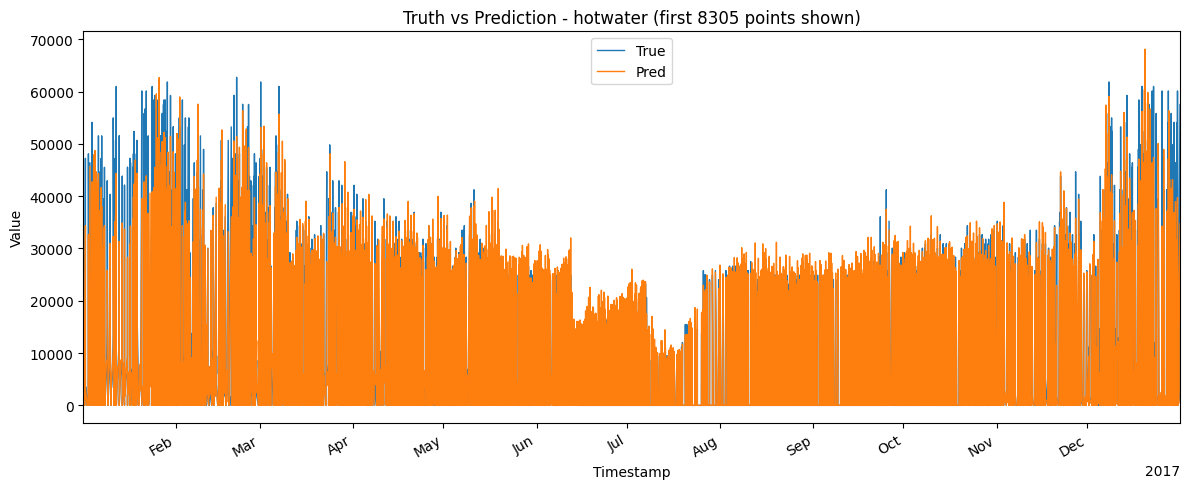


 gas → 2017-01-01 00:00:00 ~ 2017-12-31 20:00:00 (total 8219)


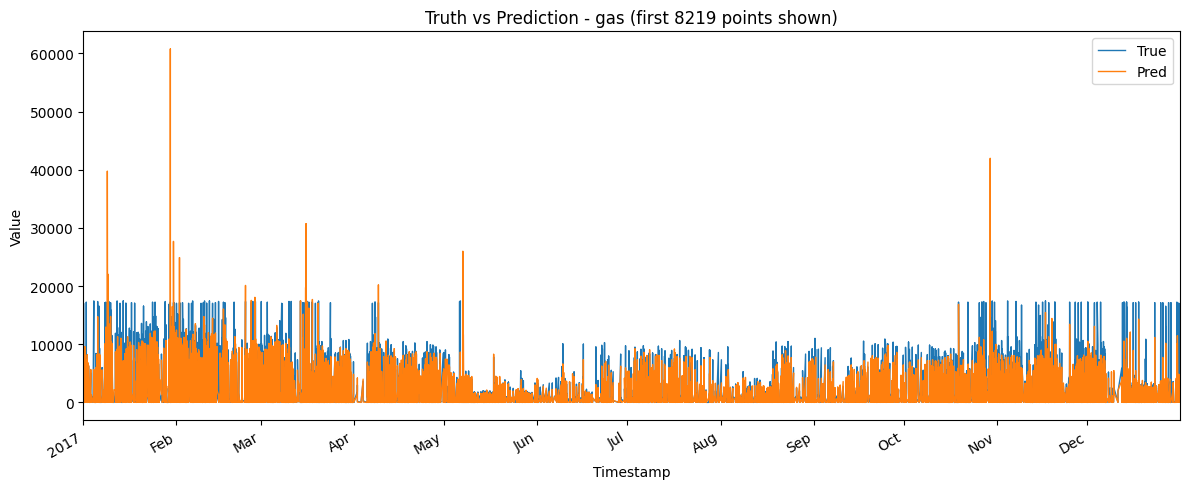


 irrigation → 2017-01-01 00:00:00 ~ 2017-12-31 20:00:00 (total 7474)


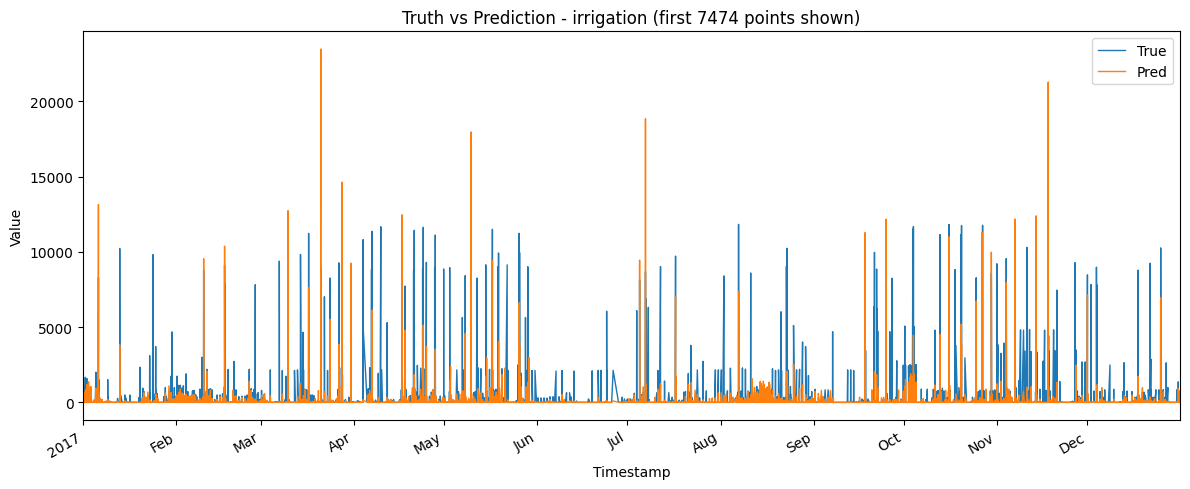


 steam → 2017-01-06 07:00:00 ~ 2017-12-13 00:00:00 (total 143)


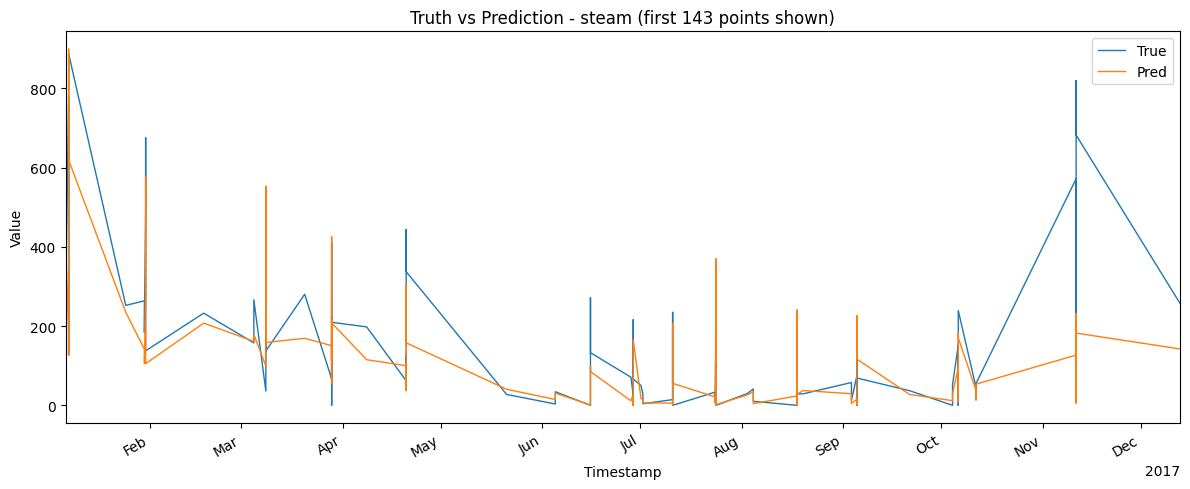

In [18]:

   
# 4) Truth vs Prediction — 상위 meter들 (timestamp 축 + 다운샘플)
   
if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    meter_order = d["meter_type"].value_counts().index.tolist()
    first_ns = [200000, 200000, 200000, 200000, 200000, 200000, 200000]

    for idx in range(min(7, len(meter_order))):
        top = meter_order[idx]
        dd = d[d["meter_type"] == top].copy()

        # 시간축 우선 정렬
        if "timestamp" in dd.columns and dd["timestamp"].notna().any():
            dd = dd.sort_values("timestamp")
            print("\n", top, "→", dd["timestamp"].min(), "~", dd["timestamp"].max(), f"(total {len(dd)})")
        else:
            dd = dd.sort_values("seq_index")

        # 표시 구간 제한
        window = min(first_ns[idx], len(dd))
        ddw = dd.iloc[:window].reset_index(drop=True)

        # 표시용 다운샘플(시각화만)
        ddw = _downsample_df(ddw, max_points=8000)

        x = _x_axis_series(ddw)
        x_label = "Timestamp" if ("timestamp" in ddw.columns and ddw["timestamp"].notna().any()) else "Sequence Index"

        plt.figure(figsize=(12, 5))
        plt.plot(x, ddw["y_true"], label="True", linewidth=1)
        plt.plot(x, ddw["y_pred"], label="Pred", linewidth=1)
        ax = plt.gca()
        _maybe_format_timeaxis(ax, x)
        plt.title(f"Truth vs Prediction - {top} (first {len(ddw)} points shown)")
        plt.xlabel(x_label)
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()


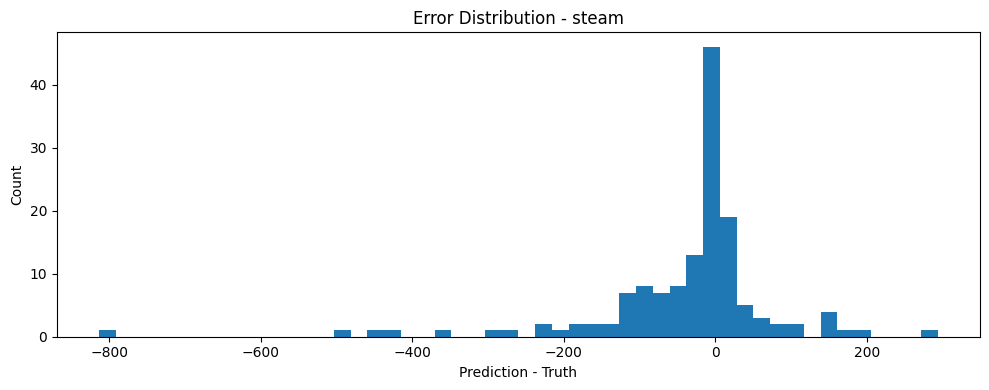

In [19]:

   
# 5) Error distribution (직전 dd/top 사용 가능 시)
   
if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    try:
        err = dd["y_pred"] - dd["y_true"]
        plt.figure(figsize=(10, 4))
        plt.hist(err.dropna().values, bins=50)
        plt.title(f"Error Distribution - {top}")
        plt.xlabel("Prediction - Truth")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    except NameError:
        pass


In [20]:

#     
# 6) Policy sample
#     
if "policy" in dfs and not dfs["policy"].empty:
    print("Policy events sample:")
    print(dfs["policy"].head(10))


Policy events sample:
                   timestamp       building_id   meter_type     value  \
0  2016-01-05T06:00:00+00:00  unknown_building  electricity -0.015757   
1  2016-01-05T10:00:00+00:00  unknown_building  electricity -0.019182   
2  2016-01-05T14:00:00+00:00  unknown_building  electricity -0.007538   
3  2016-01-06T00:00:00+00:00  unknown_building  electricity -0.008043   
4  2016-01-07T00:00:00+00:00  unknown_building  electricity -0.007049   
5  2016-01-08T00:00:00+00:00  unknown_building  electricity -0.012922   
6  2016-01-08T18:00:00+00:00  unknown_building  electricity  0.002325   
7  2016-01-09T06:00:00+00:00  unknown_building  electricity  0.006367   
8  2016-01-09T14:00:00+00:00  unknown_building  electricity -0.037920   
9  2016-01-10T06:00:00+00:00  unknown_building  electricity  0.014557   

   indoor_temperature_pred  occupancy_pred  horizon  
0                      NaN             NaN        0  
1                      NaN             NaN        1  
2           

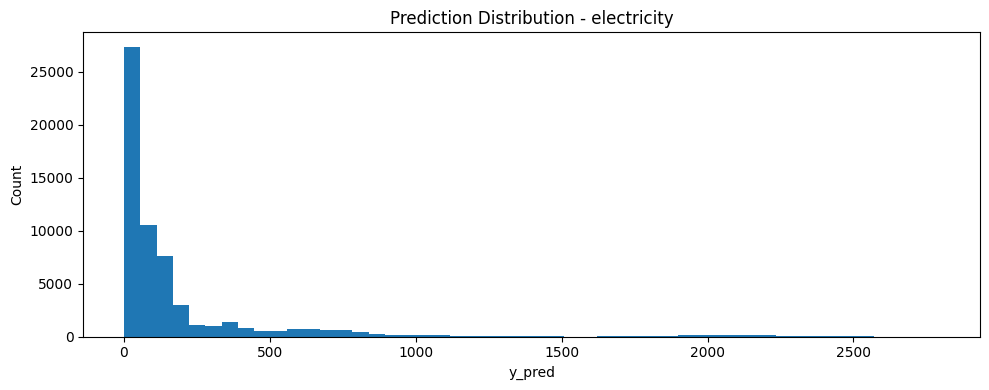

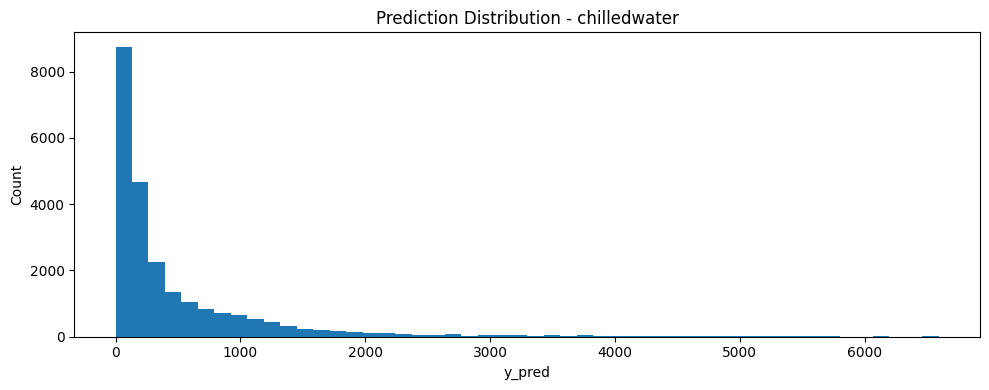

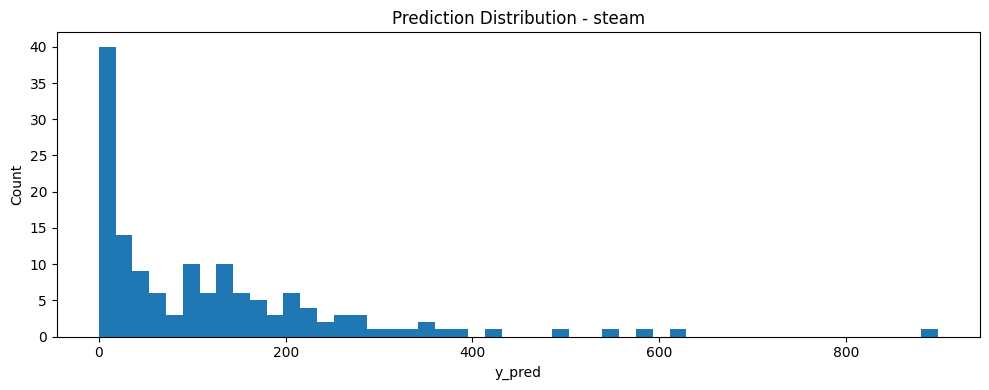

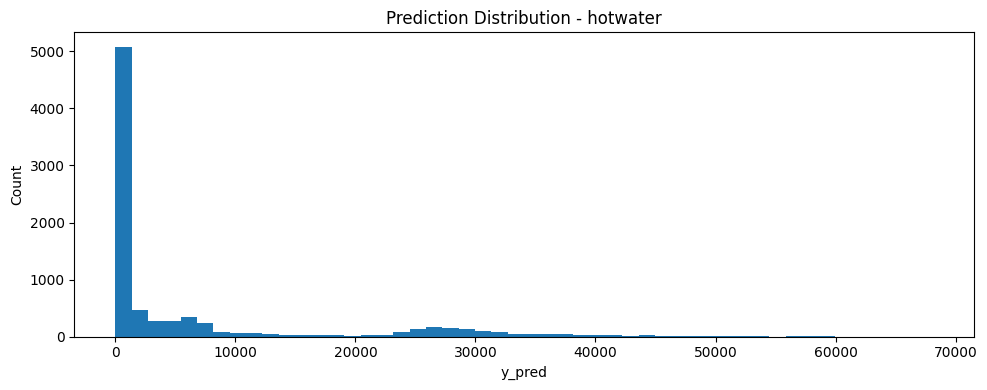

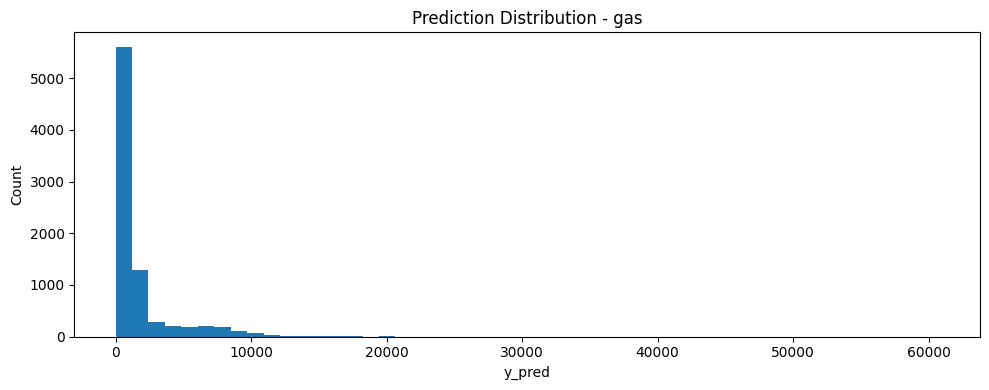

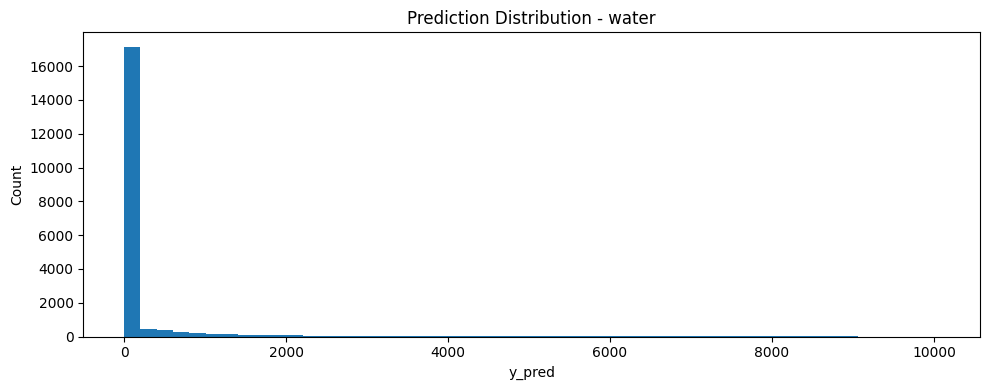

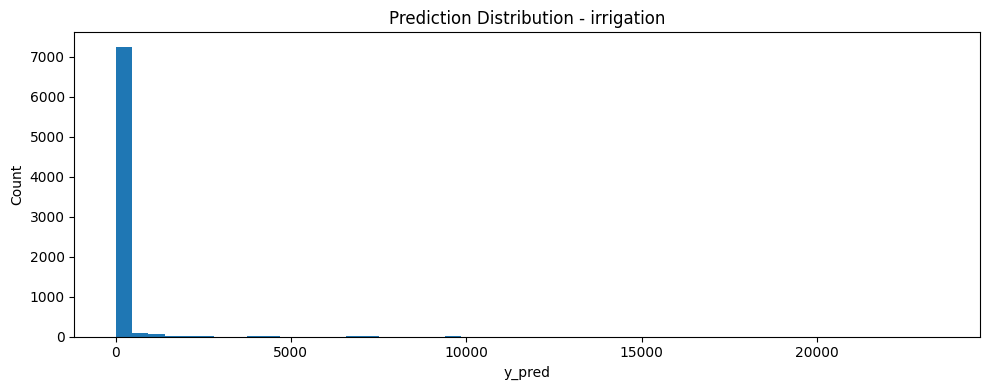

In [21]:


# 7) meter_type별 예측 분포 (히스토그램)

if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    for mtype in d["meter_type"].unique():
        dm = d[d["meter_type"] == mtype]
        if dm.empty:
            continue
        plt.figure(figsize=(10, 4))
        plt.hist(dm["y_pred"].dropna().values, bins=50)
        plt.title(f"Prediction Distribution - {mtype}")
        plt.xlabel("y_pred")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


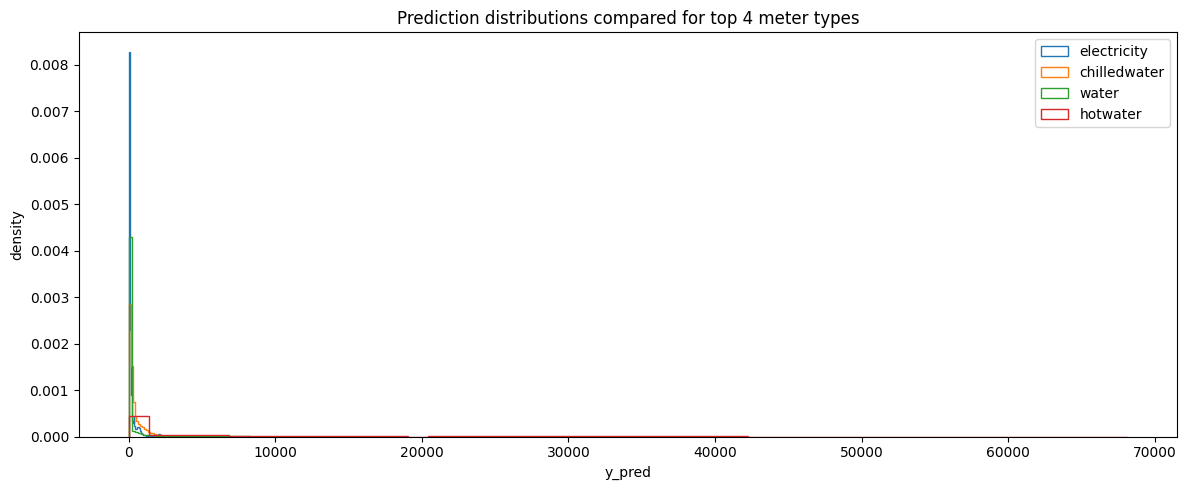

In [22]:

   
# 8) 여러 meter_type 예측 분포 비교(겹쳐 그리기; density)
   
if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    top_k = 4
    meters = d["meter_type"].value_counts().index.tolist()[:top_k]
    data_list, labels = [], []
    for mtype in meters:
        vals = d.loc[d["meter_type"] == mtype, "y_pred"].dropna().values
        if len(vals) > 0:
            data_list.append(vals); labels.append(mtype)

    if len(data_list) >= 2:
        plt.figure(figsize=(12, 5))
        for vals, lab in zip(data_list, labels):
            plt.hist(vals, bins=50, density=True, histtype="step", label=lab)
        plt.title(f"Prediction distributions compared for top {len(labels)} meter types")
        plt.xlabel("y_pred"); plt.ylabel("density")
        plt.legend(); plt.tight_layout(); plt.show()
    else:
        print("Not enough meter types to compare on a single figure")


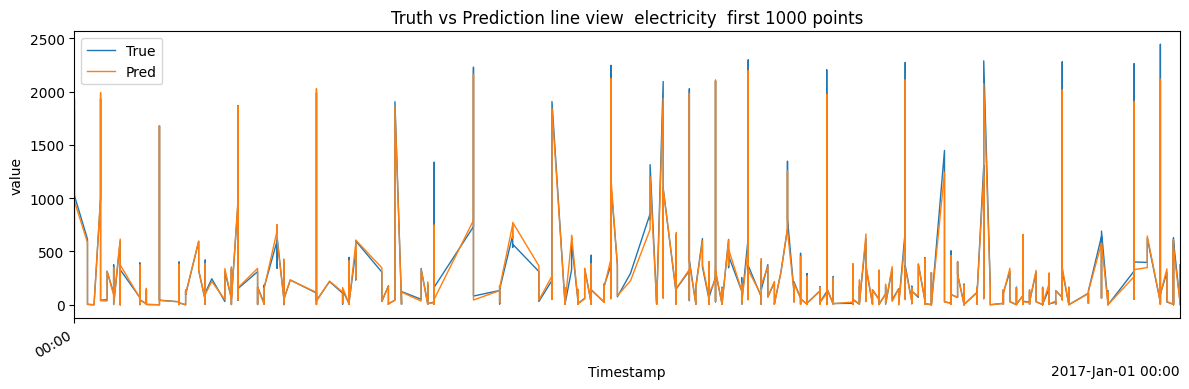

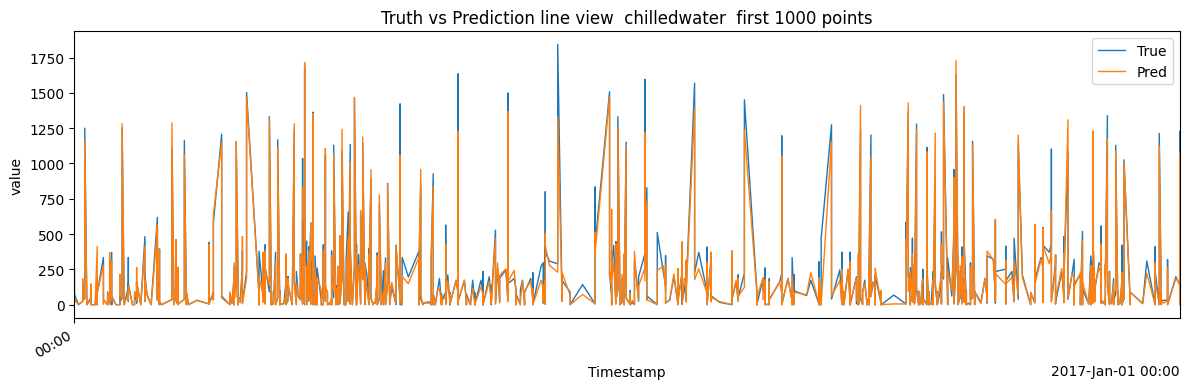

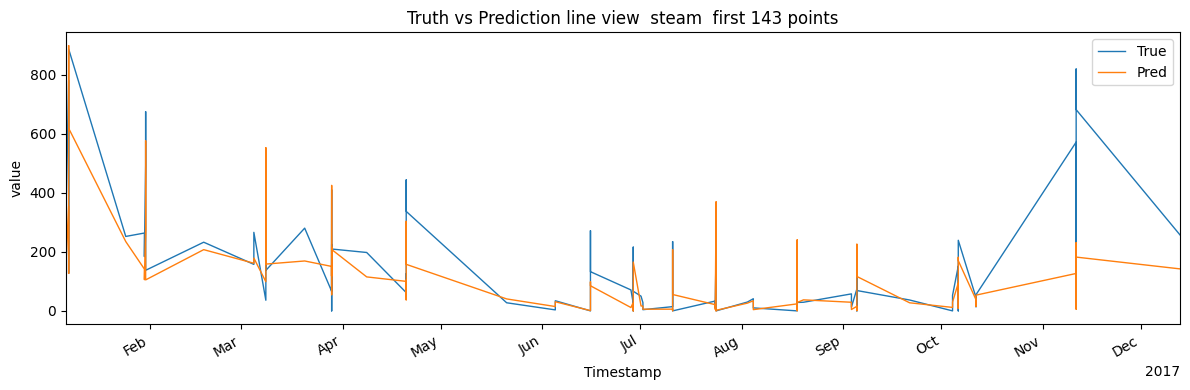

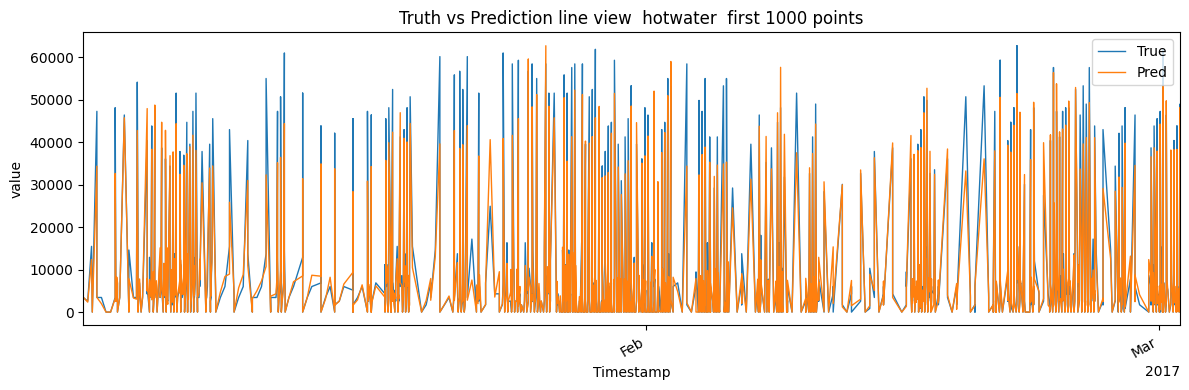

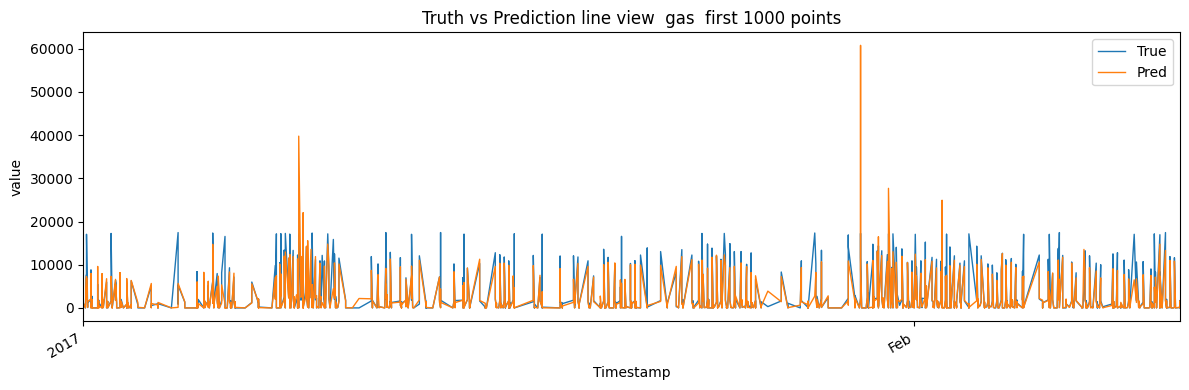

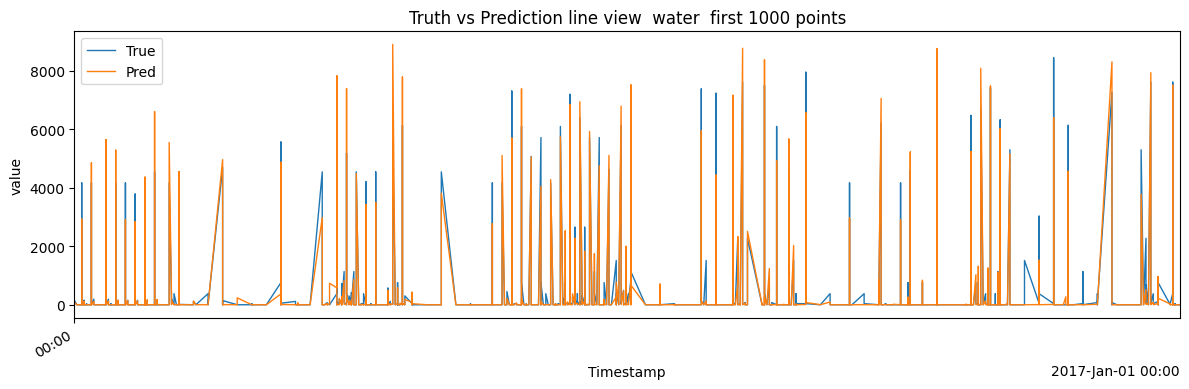

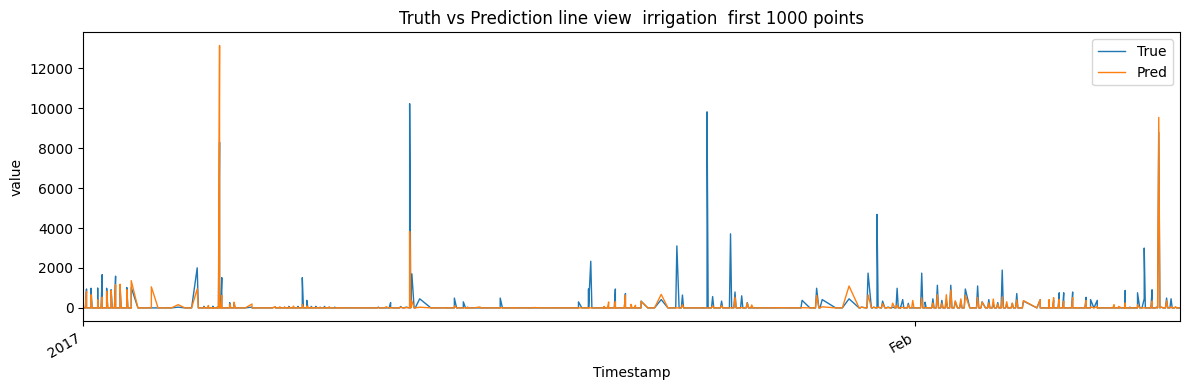

In [23]:


# 9) meter별 짧은 라인 구간 (timestamp 축)

if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    window = 1000
    for mtype in d["meter_type"].unique():
        dm = d[d["meter_type"] == mtype].copy()
        if dm.empty:
            continue
        if "timestamp" in dm.columns and dm["timestamp"].notna().any():
            dm = dm.sort_values("timestamp")
        else:
            dm = dm.sort_values("seq_index")

        ddw = dm.iloc[:min(window, len(dm))].reset_index(drop=True)
        ddw = _downsample_df(ddw, max_points=3000)

        x = _x_axis_series(ddw)
        x_label = "Timestamp" if ("timestamp" in ddw.columns and ddw["timestamp"].notna().any()) else "sequence index"

        plt.figure(figsize=(12, 4))
        plt.plot(x, ddw["y_true"], label="True", linewidth=1)
        plt.plot(x, ddw["y_pred"], label="Pred", linewidth=1)
        ax = plt.gca(); _maybe_format_timeaxis(ax, x)
        plt.title(f"Truth vs Prediction line view  {mtype}  first {len(ddw)} points")
        plt.xlabel(x_label); plt.ylabel("value")
        plt.legend(); plt.tight_layout(); plt.show()


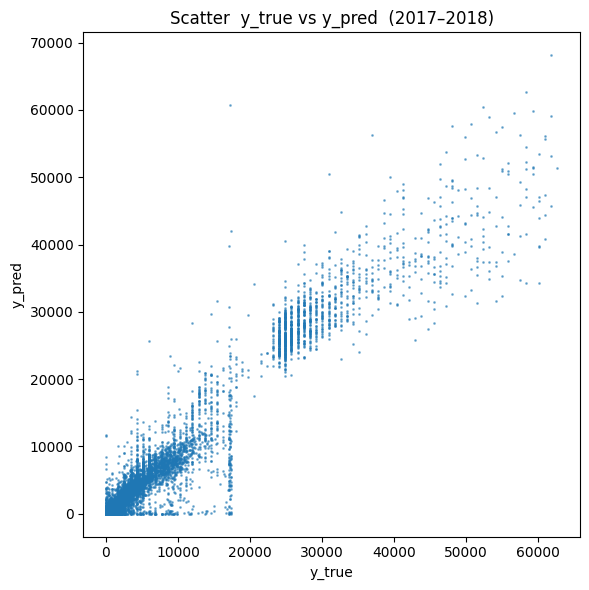

In [24]:


# 10) 전체 산점도 y_true vs y_pred

if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"][["y_true","y_pred"]].dropna()
    n = len(d); max_points = 200000
    if n > max_points:
        d = d.sample(max_points, random_state=42)
    plt.figure(figsize=(6, 6))
    plt.scatter(d["y_true"], d["y_pred"], s=1, alpha=0.5)
    plt.title("Scatter  y_true vs y_pred  (2017–2018)")
    plt.xlabel("y_true"); plt.ylabel("y_pred")
    plt.tight_layout(); plt.show()


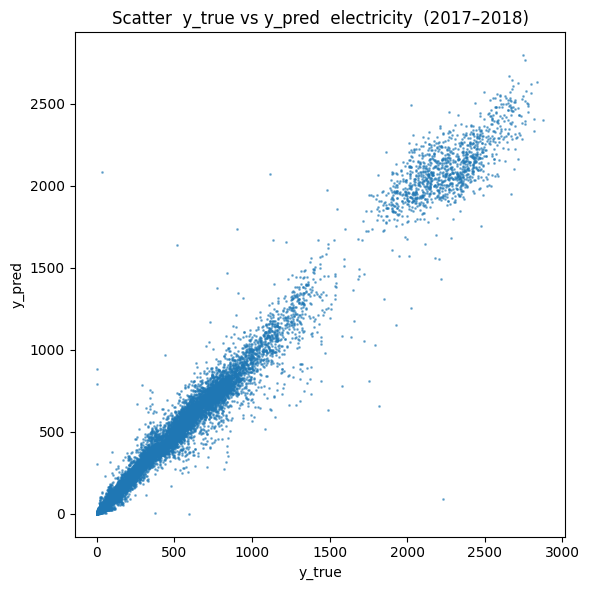

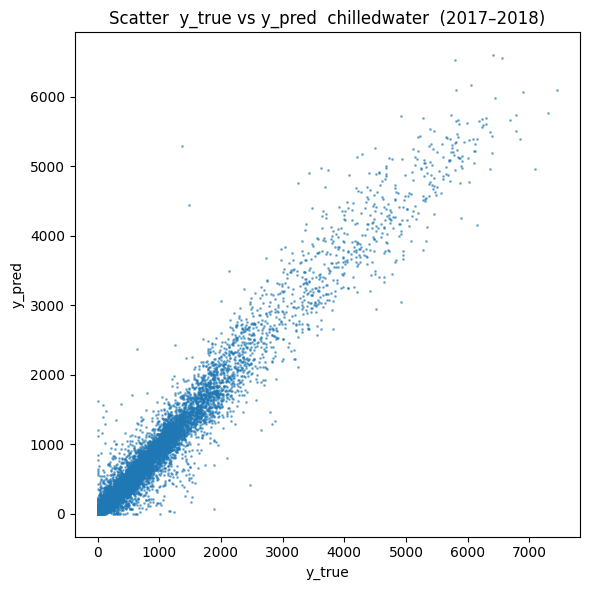

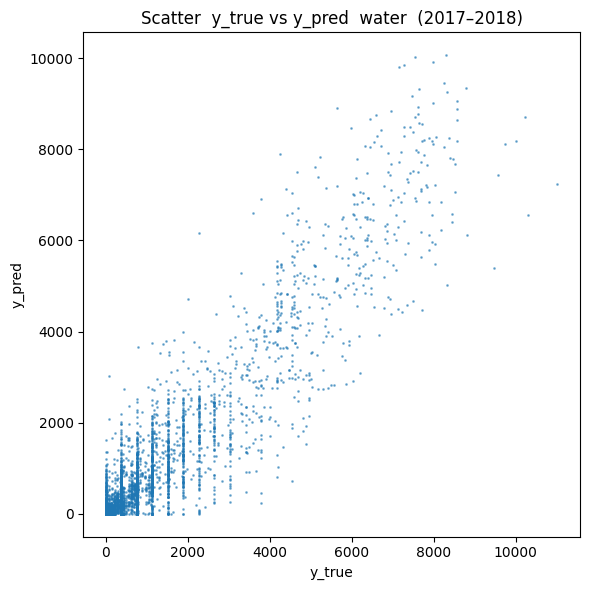

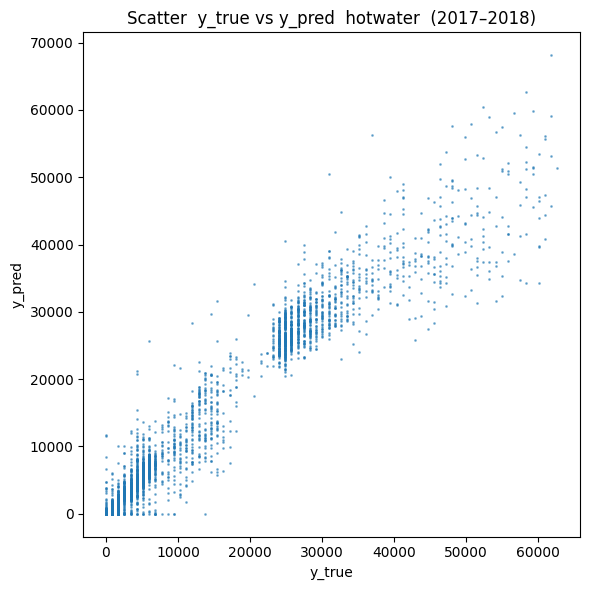

In [25]:


# 11) meter별 산점도 y_true vs y_pred

if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    top_k = 4
    meters = d["meter_type"].value_counts().index.tolist()[:top_k]
    for mtype in meters:
        dm = d[d["meter_type"] == mtype][["y_true","y_pred"]].dropna()
        if dm.empty:
            continue
        max_points = 100000
        if len(dm) > max_points:
            dm = dm.sample(max_points, random_state=42)
        plt.figure(figsize=(6, 6))
        plt.scatter(dm["y_true"], dm["y_pred"], s=1, alpha=0.5)
        plt.title(f"Scatter  y_true vs y_pred  {mtype}  (2017–2018)")
        plt.xlabel("y_true"); plt.ylabel("y_pred")
        plt.tight_layout(); plt.show()


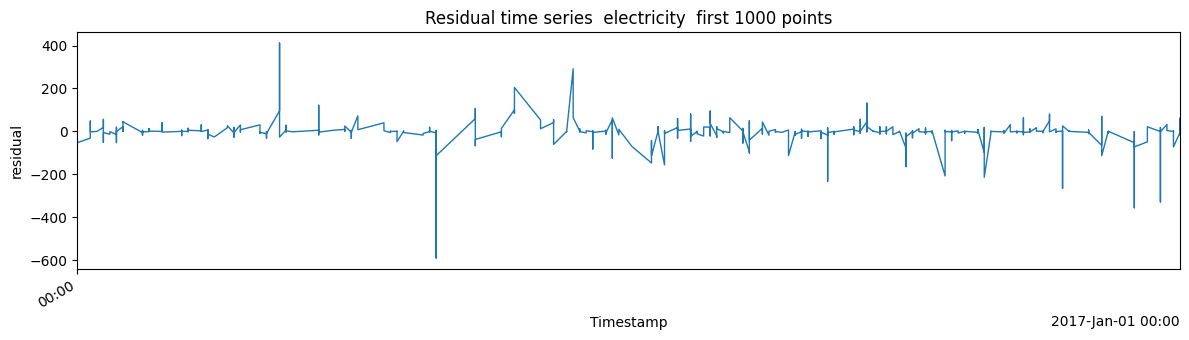

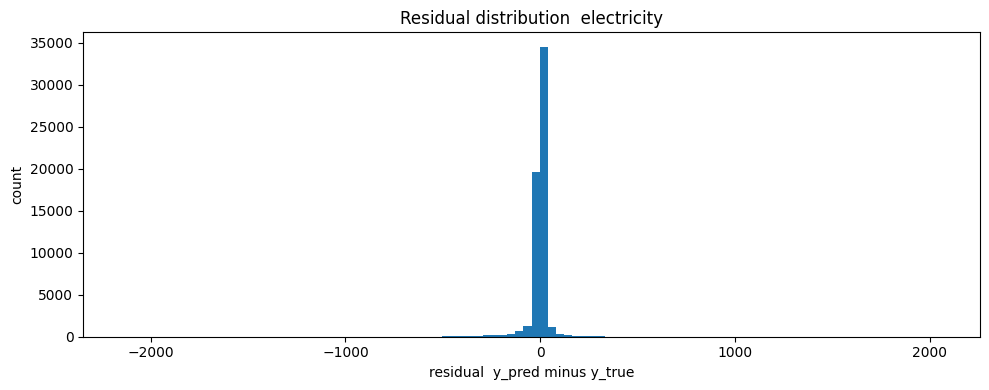

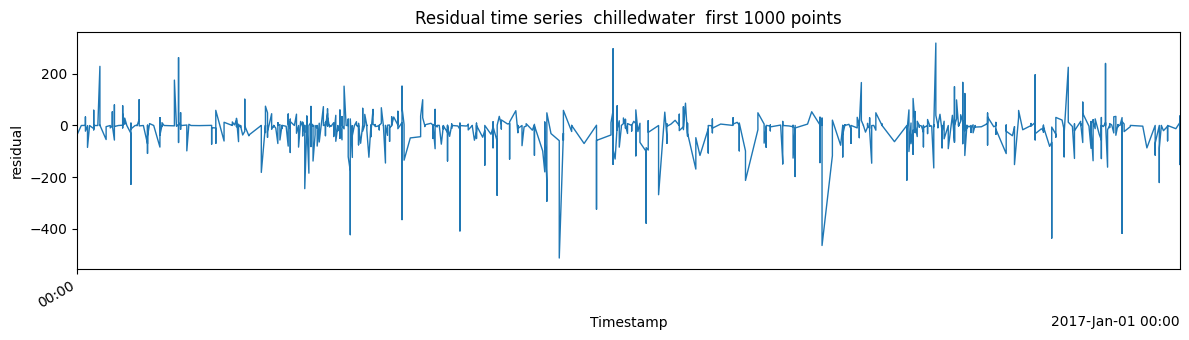

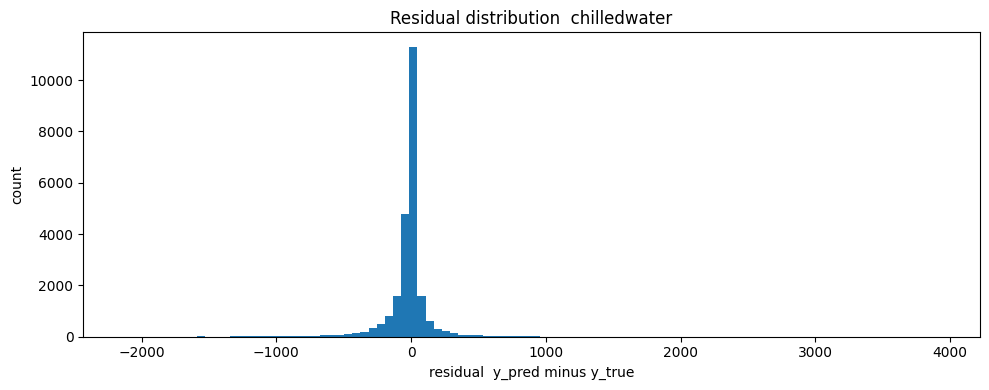

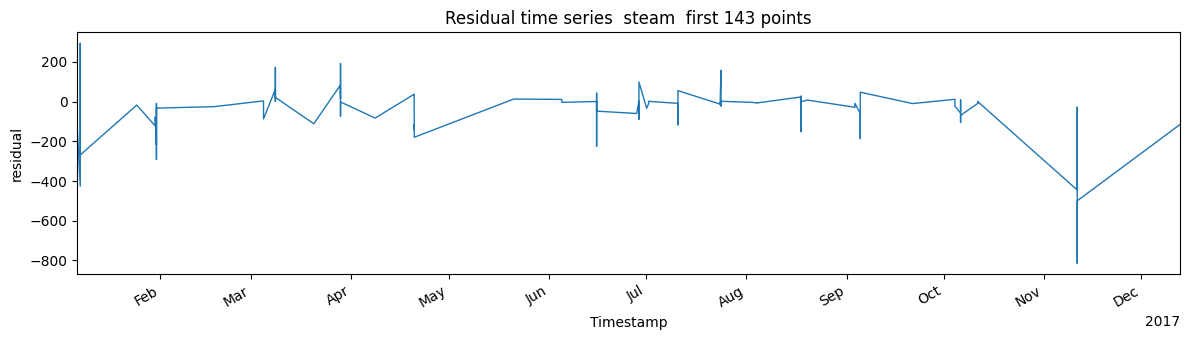

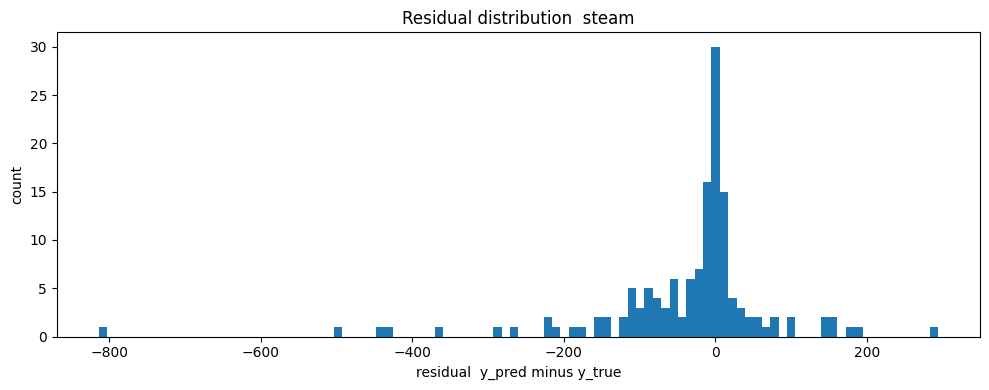

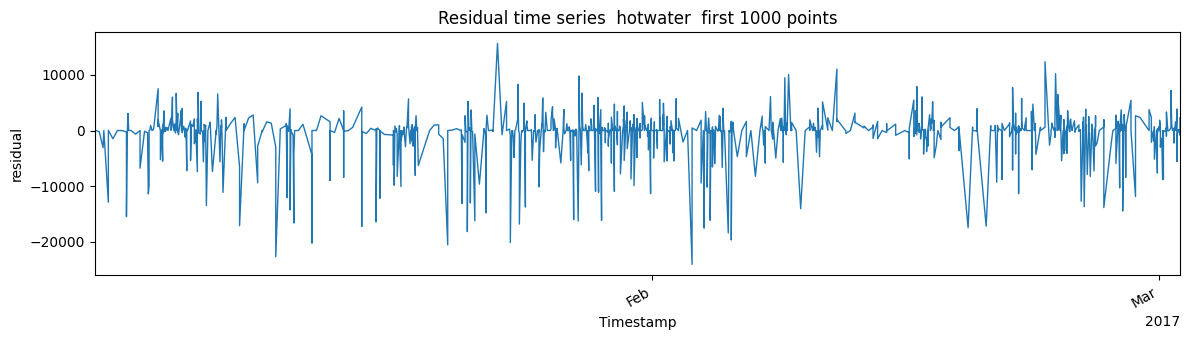

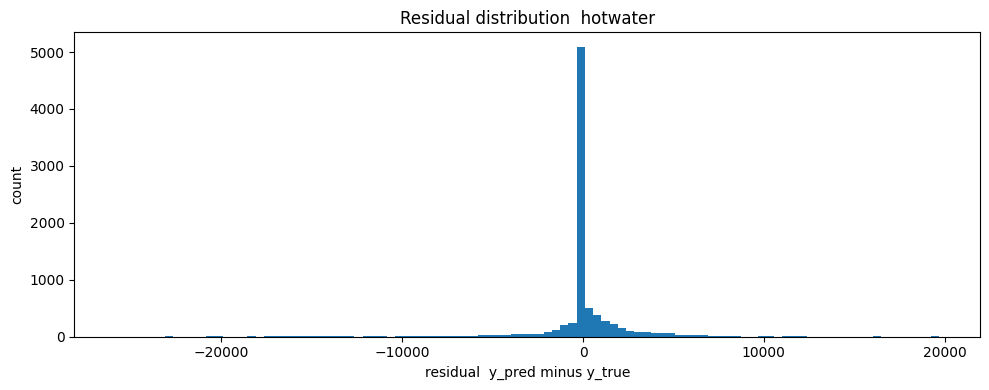

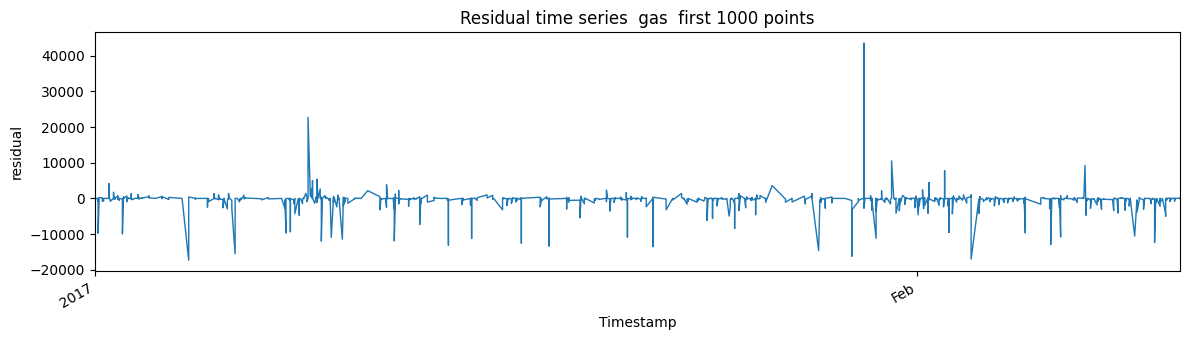

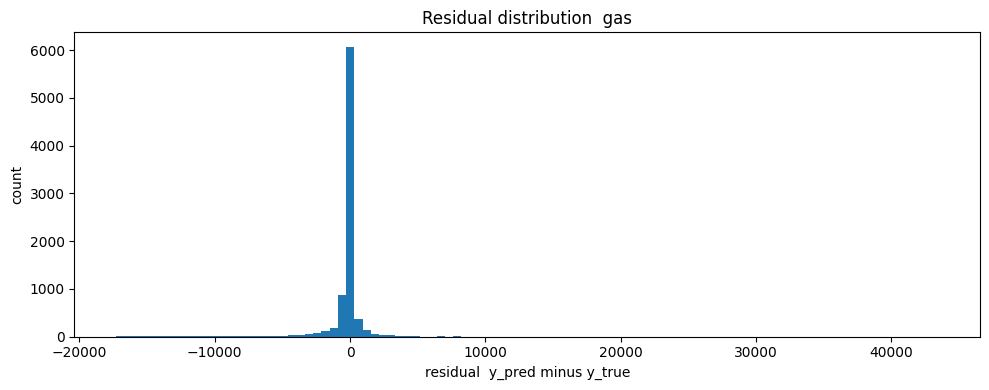

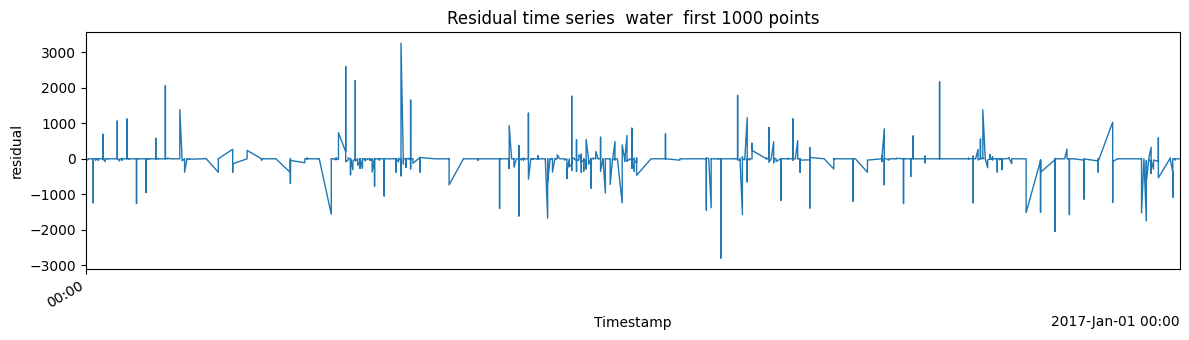

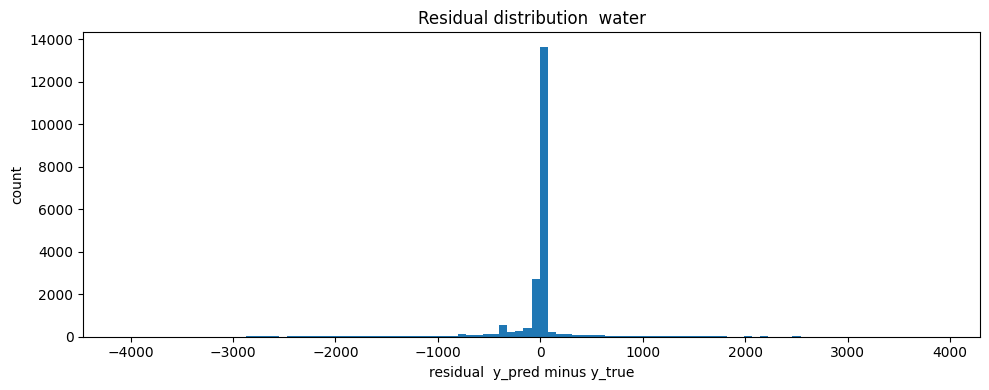

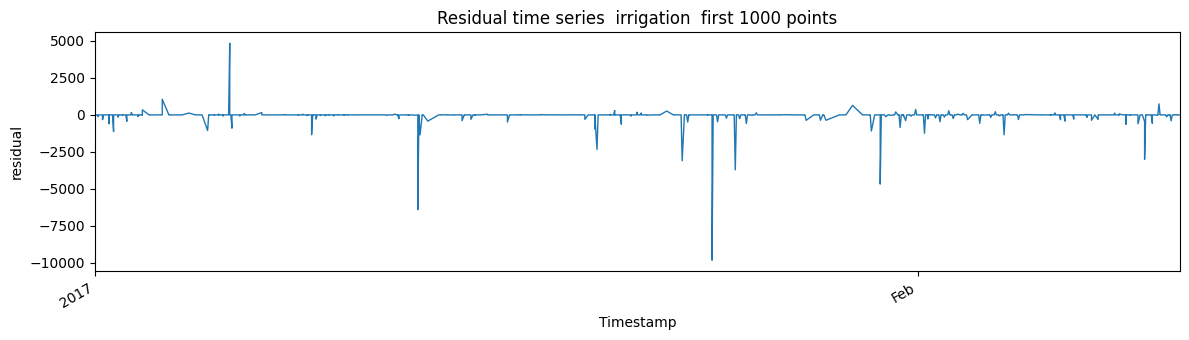

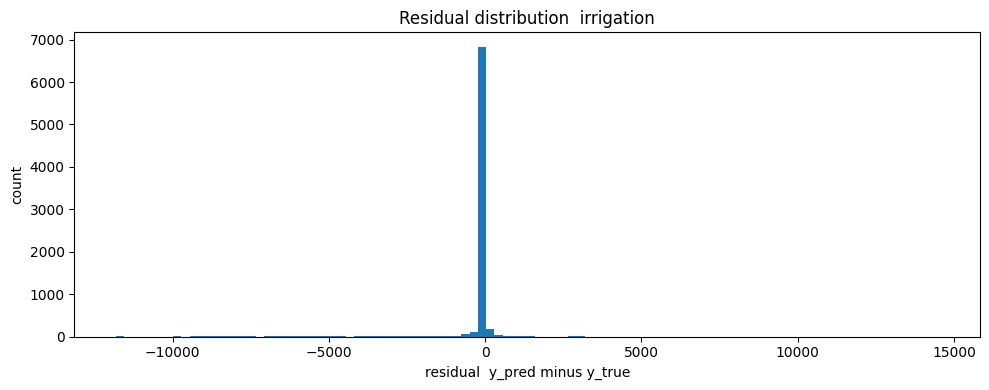

In [26]:


# 12) 잔차 분석 — timestamp 축 + 다운샘플

if "preds_vis" in dfs and not dfs["preds_vis"].empty:
    d = dfs["preds_vis"].copy()
    window = 1000
    for mtype in d["meter_type"].unique():
        dm = d[d["meter_type"] == mtype].copy()
        if dm.empty:
            continue
        if "timestamp" in dm.columns and dm["timestamp"].notna().any():
            dm = dm.sort_values("timestamp")
        else:
            dm = dm.sort_values("seq_index")

        dm["residual"] = dm["y_pred"] - dm["y_true"]
        ddw = dm.iloc[:min(window, len(dm))].reset_index(drop=True)
        ddw = _downsample_df(ddw, max_points=3000)

        x = _x_axis_series(ddw)
        x_label = "Timestamp" if ("timestamp" in ddw.columns and ddw["timestamp"].notna().any()) else "sequence index"

        plt.figure(figsize=(12, 3.5))
        plt.plot(x, ddw["residual"], linewidth=1)
        ax = plt.gca(); _maybe_format_timeaxis(ax, x)
        plt.title(f"Residual time series  {mtype}  first {len(ddw)} points")
        plt.xlabel(x_label); plt.ylabel("residual")
        plt.tight_layout(); plt.show()

        plt.figure(figsize=(10, 4))
        plt.hist(dm["residual"].dropna().values, bins=100)
        plt.title(f"Residual distribution  {mtype}")
        plt.xlabel("residual  y_pred minus y_true"); plt.ylabel("count")
        plt.tight_layout(); plt.show()
